In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt
import torch.nn.init as init
import time
import random

In [2]:
def np_to_torch(arr):
    
    arr = torch.FloatTensor(arr)
    arr = arr.unsqueeze(-1)
    arr = arr.clone().detach().requires_grad_(True)
    
    return arr

def xy_train_data(N_x, x_l, x_r, N_y, y_b, y_t, N_bc, r, r_ex, xb, yb):
    
    x_train = []
    y_train = []
    
    #Collocation points
    dx = (x_r - x_l)/(N_x - 1)
    dy = (y_t - y_b)/(N_y - 1)
    
    for i in range(N_x):
        for j in range(N_y):
            
            x = x_l + i*dx
            y = y_b + j*dy
            
            if( (x-xb)**2 + (y-yb)**2 > (r+r_ex)**2):
                x_train.append(x)
                y_train.append(y)
                 
    # Points with boundary and interface
    N_i = 100
    for a in np.arange(0.001, r_ex, 0.004, dtype=float):
        for i in range(N_i):
            x_train.append(xb + (r+a)*np.cos(i*2*math.pi/N_i))
            y_train.append(yb + (r+a)*np.sin(i*2*math.pi/N_i))
        N_i = N_i + 15
        
#     # initial Interface points
#     N_i = 16*N_bc
#     for i in range(N_i):
#         x_train.append(xb + (r+r_ex)*np.cos(i*2*math.pi/N_i))
#         y_train.append(yb + (r+r_ex)*np.sin(i*2*math.pi/N_i))
        
    # Boundary points
    for i in range(N_bc):
        x_train.append(xb + r*np.cos(i*2*math.pi/N_bc))
        y_train.append(yb + r*np.sin(i*2*math.pi/N_bc))
    
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    x_train = np_to_torch(x_train)
    y_train = np_to_torch(y_train)
    
    return x_train, y_train

def initial_temp(x_train, y_train, N_tot, N_bc, T_l, T_r, x_l, y_t, y_b):
    
    T_prev = np.ones(N_tot)*T_r
    x_train = x_train.detach().numpy()
    y_train = y_train.detach().numpy()
    for i in range(-1, -N_bc-1, -1):
        T_prev[i] = T_l      
    T_prev = np_to_torch(T_prev)
    
    return T_prev

def initial_fraction(N_tot, x_train, y_train, xb, yb, r, r_ex):
    
    f_prev = np.zeros(N_tot)
    x_train = x_train.detach().numpy()
    y_train = y_train.detach().numpy()
    cnt = 0
    for i in range(N_tot):
        
        if (x_train[i] - xb)**2 + (y_train[i] - yb)**2 <= (r+r_ex)**2:
            f_prev[i] = 1
            cnt = cnt + 1
    
    f_prev = np_to_torch(f_prev)
    print(cnt)
    return f_prev

def xavier_init(m):
    if isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0.01)
    
class ANN(nn.Module):
    def __init__(self, layer_size):
        super(ANN, self).__init__()
        
        # Fully conected model-1
        modules_1 = []
        for i in range(len(layer_size) - 1):
            modules_1.append(nn.Linear(layer_size[i], layer_size[i+1]))  
            if i < ( len(layer_size) - 2 ):
                modules_1.append(nn.Tanh())
        
        modules_1.append(nn.ReLU())
        self.fc_1 = nn.Sequential(*modules_1)
        for layer in self.fc_1.modules():
            if isinstance(layer, nn.Linear):
                 layer.weight.data.normal_(mean=0.45, std=0.3)
       
        modules_2 = []
        for i in range(len(layer_size) - 1):
            modules_2.append(nn.Linear(layer_size[i], layer_size[i+1]))  
            if i != len(layer_size) - 2 :
                modules_2.append(nn.Tanh())
        
#         modules_2.append(nn.Softplus(beta=3))
        self.fc_2 = nn.Sequential(*modules_2)
        for layer in self.fc_2.modules():
            if isinstance(layer, nn.Linear):
                 layer.weight.data.normal_(mean=0, std=0.4)
    
    def forward(self, x_train, y_train):
        
        T = self.fc_1( torch.cat((x_train, y_train),1) )
        dTdx = torch.autograd.grad(T, x_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
        d2Tdx2 = torch.autograd.grad(dTdx, x_train, grad_outputs=torch.ones_like(dTdx), create_graph=True)[0]
        dTdy = torch.autograd.grad(T, y_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
        d2Tdy2 = torch.autograd.grad(dTdy, y_train, grad_outputs=torch.ones_like(dTdy), create_graph=True)[0]
        
        f = self.fc_2( torch.cat((x_train, y_train),1) )
        
        return T, dTdx, dTdy, d2Tdx2, d2Tdy2, f
    
def get_loss(x_train, y_train, k1, k2, del_t, T_l, w1, w2, w3, w4, w5, w6,
             T_prev, f_prev, f_lim, mat_1, mat_2, mat_3, N_tot, N_1, N_2, N_3):

    T, dTdx, dTdy, d2Tdx2, d2Tdy2, f = model(x_train, y_train)
    
    mat_4 = torch.where(f_prev>= f_lim,1,0)
    N_4 = torch.sum( mat_1 )
    m = nn.Sigmoid()
    
    eq1 = w1*torch.sum( torch.mul( torch.square( T - T_prev - del_t*k1*(d2Tdx2 + d2Tdy2) ), mat_4) )/(N_4)
    eq2 = w2*torch.sum( torch.mul( torch.square( f - f_prev - del_t*k2*(d2Tdx2 + d2Tdy2) ), 1-mat_4) )/(N_tot - N_4)
    bc1 = w3*torch.sum( torch.square( torch.mul(mat_1, T - T_l ) ) )/(N_1)
    bc2 = w4*torch.sum( torch.square( torch.mul(mat_2, T ) ) )/(N_2)
    bc3 = w5*torch.sum( torch.square( torch.mul(mat_3, T ) ) )/(N_3)
    bc4 = w4*torch.sum( torch.square( torch.mul(1-mat_4, T ) ) )/(N_tot - N_4)
    bc5 = w4*torch.sum( torch.square( torch.mul(mat_4, m(-30*T) ) ) )/(N_4)
    
    if(N_4 == 0):
        eq1 = 0
    if(N_tot - N_4 == 0):
        eq2 = 0
        bc4 = 0
    
    loss = eq1 + eq2 + bc1 + bc2 + bc3 + bc4 + bc5
    
    return loss, eq1, eq2, bc1, bc2, bc3, bc4, bc5

def print_loss(epoch, loss, eq1, eq2, bc1, bc2, bc3, bc4, bc5):
    print('epoch = ',epoch)
    print('loss = ',loss)
    print('eq1_loss = ',eq1)
    print('eq2_loss = ',eq2)
    print('bc1_loss = ',bc1)
    print('bc2_loss = ',bc2)
    print('bc3_loss = ',bc3)
    print('bc4_loss = ',bc4)
    print('bc5_loss = ',bc5)
    
def temperature_fraction_correction(f_new, f_prev, T_new, N_tot, T_r):
    
    for i in range(N_tot):
        
        if f_new[i][0]>=1 or f_prev[i][0]>=1:
            f_new[i][0] = 1
            continue
            
        if f_new[i][0]<0:
            f_new[i][0] = 0
    
    f_new = torch.FloatTensor(f_new)  
    T_new = torch.FloatTensor(T_new)   
    return T_new, f_new

In [3]:
N_x = 61
N_y = 61
N_bc = 101

x_l = 0
y_b = 0
x_r = 1
y_t = 1
xb = 0.5
yb = 0.5
r = 0.2
r_ex = 0.02

N_t = 2000
del_t = 0.025

f_lim = 1

T_l = 1
T_r = 0

# material params
k1 = 0.0263
k2 = 0.0044

# Training data and initial data
layer_size = [2, 7, 7, 1]
model = ANN(layer_size)
print(model)
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable parameters in the model:", total_trainable_params)

# Setup Loss function and Optimiser
epochs =140001
lr1 = 8.5e-5
lr2 = 7.5e-5
optimiser1 = torch.optim.Adam(model.parameters(), lr=lr1)
optimiser2 = torch.optim.Adam(model.parameters(), lr=lr2)

ANN(
  (fc_1): Sequential(
    (0): Linear(in_features=2, out_features=7, bias=True)
    (1): Tanh()
    (2): Linear(in_features=7, out_features=7, bias=True)
    (3): Tanh()
    (4): Linear(in_features=7, out_features=1, bias=True)
    (5): ReLU()
  )
  (fc_2): Sequential(
    (0): Linear(in_features=2, out_features=7, bias=True)
    (1): Tanh()
    (2): Linear(in_features=7, out_features=7, bias=True)
    (3): Tanh()
    (4): Linear(in_features=7, out_features=1, bias=True)
  )
)
Total trainable parameters in the model: 170


In [4]:
# Lists for storing
loss_store = []
f_store_pred = []
T_store_pred = []
t_store = []
model.train()  

# Initial conditions
x_train, y_train = xy_train_data(N_x, x_l, x_r, N_y, y_b, y_t, N_bc, r, r_ex, xb, yb)
N_tot = x_train.shape[0]
T_prev = initial_temp(x_train, y_train, N_tot, N_bc, T_l, T_r, x_l, y_t, y_b)
f_prev = initial_fraction(N_tot, x_train, y_train, xb, yb, r, r_ex)
t_test = 0
T_store_pred.append(T_prev.detach().numpy())
f_store_pred.append(f_prev.detach().numpy())
# Loss function weights
w1 = 1
w2 = 1
w3 = 1
w4 = 1
w5 = 1
w6 = 1

mat_1 = np.ones(N_tot)
N_1 = N_bc
for i in range(N_tot - N_1):
    mat_1[i] = 0
mat_1 = np_to_torch(mat_1)
mat_2 = torch.where(x_train == x_l,1,0) + torch.where(x_train == x_r,1,0)
N_2 = torch.sum( mat_2 )
mat_3 = torch.where(y_train == y_t,1,0) + torch.where(y_train == y_b,1,0)
N_3 = torch.sum( mat_3 )

print(N_tot, N_1, N_2, N_3)
for i in range(N_t):

    t_test = t_test + del_t
    t_store.append(t_test)
    print("t = ", t_test)
    print(" ")
    
    if(i>0):
        epochs = 5001

    for epoch in range(epochs):        
        #Backpropogation and optimisation
        loss, eq1, eq2, bc1, bc2, bc3, bc4, bc5 = get_loss(x_train, y_train, k1, k2, del_t, 
                                                      T_l, w1, w2, w3, w4, w5, w6,
                                                      T_prev, f_prev, f_lim, mat_1, mat_2,
                                                      mat_3, N_tot, N_1, N_2, N_3)
        loss_store.append(loss.detach().numpy())
        optimiser1.zero_grad()
        loss.backward()
        optimiser1.step()
        
        if epoch%2000==0:
            print_loss(epoch, loss, eq1, eq2, bc1, bc2, bc3, bc4, bc5)
            print("")
    
    # Store the results after each time step
    T_prev, dTdx, dTdy, d2Tdx2, d2Tdy2, f_prev = model(x_train, y_train)
    T_prev, f_prev = temperature_fraction_correction(f_prev.detach().numpy(), f_store_pred[-1], T_prev.detach().numpy(), N_tot, T_r)
    
    T_store_pred.append(T_prev.detach().numpy())
    f_store_pred.append(f_prev.detach().numpy())
    
    T_prev = torch.FloatTensor(T_store_pred[-1]).clone().detach().requires_grad_(False)
    f_prev = torch.FloatTensor(f_store_pred[-1]).clone().detach().requires_grad_(False)

751
3919 101 tensor(122) tensor(122)
t =  0.025
 
epoch =  0
loss =  tensor(81.0326, grad_fn=<AddBackward0>)
eq1_loss =  tensor(56.0901, grad_fn=<DivBackward0>)
eq2_loss =  tensor(0.5204, grad_fn=<DivBackward0>)
bc1_loss =  tensor(3.4663, grad_fn=<DivBackward0>)
bc2_loss =  tensor(7.3618, grad_fn=<DivBackward0>)
bc3_loss =  tensor(7.2218, grad_fn=<DivBackward0>)
bc4_loss =  tensor(6.3723, grad_fn=<DivBackward0>)
bc5_loss =  tensor(0., grad_fn=<DivBackward0>)

epoch =  2000
loss =  tensor(3.5641, grad_fn=<AddBackward0>)
eq1_loss =  tensor(1.9025, grad_fn=<DivBackward0>)
eq2_loss =  tensor(0.0017, grad_fn=<DivBackward0>)
bc1_loss =  tensor(0.3741, grad_fn=<DivBackward0>)
bc2_loss =  tensor(0.5075, grad_fn=<DivBackward0>)
bc3_loss =  tensor(0.4625, grad_fn=<DivBackward0>)
bc4_loss =  tensor(0.3145, grad_fn=<DivBackward0>)
bc5_loss =  tensor(0.0013, grad_fn=<DivBackward0>)

epoch =  4000
loss =  tensor(2.2305, grad_fn=<AddBackward0>)
eq1_loss =  tensor(1.1124, grad_fn=<DivBackward0>)
eq2_l

epoch =  40000
loss =  tensor(1.0106, grad_fn=<AddBackward0>)
eq1_loss =  tensor(0.7420, grad_fn=<DivBackward0>)
eq2_loss =  tensor(2.6703e-07, grad_fn=<DivBackward0>)
bc1_loss =  tensor(0.2534, grad_fn=<DivBackward0>)
bc2_loss =  tensor(0., grad_fn=<DivBackward0>)
bc3_loss =  tensor(0., grad_fn=<DivBackward0>)
bc4_loss =  tensor(9.6464e-07, grad_fn=<DivBackward0>)
bc5_loss =  tensor(0.0151, grad_fn=<DivBackward0>)

epoch =  42000
loss =  tensor(0.9921, grad_fn=<AddBackward0>)
eq1_loss =  tensor(0.7437, grad_fn=<DivBackward0>)
eq2_loss =  tensor(3.3503e-07, grad_fn=<DivBackward0>)
bc1_loss =  tensor(0.2314, grad_fn=<DivBackward0>)
bc2_loss =  tensor(0., grad_fn=<DivBackward0>)
bc3_loss =  tensor(0., grad_fn=<DivBackward0>)
bc4_loss =  tensor(1.1668e-06, grad_fn=<DivBackward0>)
bc5_loss =  tensor(0.0170, grad_fn=<DivBackward0>)

epoch =  44000
loss =  tensor(0.9786, grad_fn=<AddBackward0>)
eq1_loss =  tensor(0.7459, grad_fn=<DivBackward0>)
eq2_loss =  tensor(3.8104e-07, grad_fn=<DivBack

epoch =  80000
loss =  tensor(0.8117, grad_fn=<AddBackward0>)
eq1_loss =  tensor(0.6766, grad_fn=<DivBackward0>)
eq2_loss =  tensor(0.0002, grad_fn=<DivBackward0>)
bc1_loss =  tensor(0.1224, grad_fn=<DivBackward0>)
bc2_loss =  tensor(2.2243e-05, grad_fn=<DivBackward0>)
bc3_loss =  tensor(0., grad_fn=<DivBackward0>)
bc4_loss =  tensor(0.0010, grad_fn=<DivBackward0>)
bc5_loss =  tensor(0.0116, grad_fn=<DivBackward0>)

epoch =  82000
loss =  tensor(0.8021, grad_fn=<AddBackward0>)
eq1_loss =  tensor(0.6716, grad_fn=<DivBackward0>)
eq2_loss =  tensor(0.0002, grad_fn=<DivBackward0>)
bc1_loss =  tensor(0.1183, grad_fn=<DivBackward0>)
bc2_loss =  tensor(4.8010e-06, grad_fn=<DivBackward0>)
bc3_loss =  tensor(0., grad_fn=<DivBackward0>)
bc4_loss =  tensor(0.0010, grad_fn=<DivBackward0>)
bc5_loss =  tensor(0.0110, grad_fn=<DivBackward0>)

epoch =  84000
loss =  tensor(0.7928, grad_fn=<AddBackward0>)
eq1_loss =  tensor(0.6668, grad_fn=<DivBackward0>)
eq2_loss =  tensor(0.0002, grad_fn=<DivBackward

epoch =  120000
loss =  tensor(0.7090, grad_fn=<AddBackward0>)
eq1_loss =  tensor(0.6388, grad_fn=<DivBackward0>)
eq2_loss =  tensor(0.0002, grad_fn=<DivBackward0>)
bc1_loss =  tensor(0.0608, grad_fn=<DivBackward0>)
bc2_loss =  tensor(0.0002, grad_fn=<DivBackward0>)
bc3_loss =  tensor(0.0001, grad_fn=<DivBackward0>)
bc4_loss =  tensor(0.0005, grad_fn=<DivBackward0>)
bc5_loss =  tensor(0.0085, grad_fn=<DivBackward0>)

epoch =  122000
loss =  tensor(0.7079, grad_fn=<AddBackward0>)
eq1_loss =  tensor(0.6389, grad_fn=<DivBackward0>)
eq2_loss =  tensor(0.0002, grad_fn=<DivBackward0>)
bc1_loss =  tensor(0.0598, grad_fn=<DivBackward0>)
bc2_loss =  tensor(0.0002, grad_fn=<DivBackward0>)
bc3_loss =  tensor(0.0001, grad_fn=<DivBackward0>)
bc4_loss =  tensor(0.0004, grad_fn=<DivBackward0>)
bc5_loss =  tensor(0.0083, grad_fn=<DivBackward0>)

epoch =  124000
loss =  tensor(0.7069, grad_fn=<AddBackward0>)
eq1_loss =  tensor(0.6384, grad_fn=<DivBackward0>)
eq2_loss =  tensor(0.0002, grad_fn=<DivBackw

KeyboardInterrupt: 

In [5]:
T_prev, dTdx, dTdy, d2Tdx2, d2Tdy2, f_prev = model(x_train, y_train)
T_prev, f_prev = temperature_fraction_correction(f_prev.detach().numpy(), f_store_pred[-1], T_prev.detach().numpy(), N_tot, T_r)

T_store_pred.append(T_prev.detach().numpy())
f_store_pred.append(f_prev.detach().numpy())

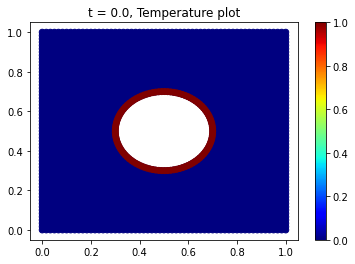

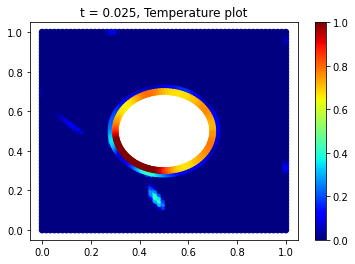

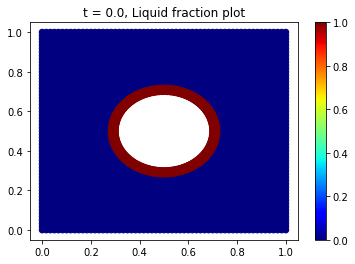

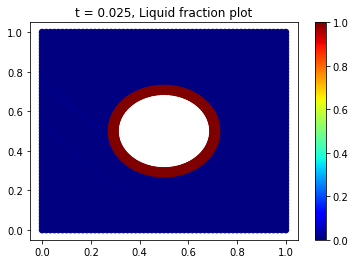

In [6]:
X = x_train.detach().numpy()
Y = y_train.detach().numpy()

k = 0
for T in T_store_pred:
    
    plt.figure()
    sc = plt.scatter(X, Y, c=T, cmap=plt.cm.jet)
    plt.clim(0,1)
    plt.colorbar(sc)
    plt.title('t = '+ str(k*del_t)+', Temperature plot')
    k = k+1

plt.show()

k = 0
for F in f_store_pred:
    
    plt.figure()
    sc = plt.scatter(X, Y, c=F, cmap=plt.cm.jet)
    plt.colorbar(sc)
    plt.title('t = '+ str(k*del_t)+', Liquid fraction plot')
    k = k+1

plt.show()

In [ ]:
list(model.parameters())